In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import scipy.stats
import phi_divergence as phi
from time import process_time

In [2]:
# Matplotlib settings:
# need to have LaTeX installed, can install with: conda install -c conda-forge miktex
import matplotlib
#import matplotlib.patches as mpatches
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['figure.dpi'] = 100

The toy model we examine is as follows:

\begin{align}\label{toy_model}
    \begin{split}
        \max_{x_1,x_2\geq 0}\{x_1+x_2: \mathbb{P}^*(\mathbf{\xi}\in [-1,1]^2: \xi_1x_1+\xi_2x_2\leq 1)\geq \beta, x_1-x_2\leq -1, x_1,x_2\leq 10\}.
    \end{split}
\end{align}

In [3]:
def toymodel(Z_arr):
    x = cp.Variable(2, nonneg = True)
    constraints = [Z_arr @ x <= 1, x[0] <= x[1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

def toymodel_true(beta):
    x = cp.Variable(2, nonneg = True)
    constraints = [x[0] <= x[1]-1, x<=10, (1-2*beta)*x[1] + 1 >= 0]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

def toymodel_large(Z_arr, size):
    x = cp.Variable(size, nonneg = True)
    constraints = [Z_arr @ x <= 1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

def lowbound(p,r, par, phi_div):
    q = cp.Variable(2, nonneg = True)
    constraints = [cp.sum(q) == 1]
    constraints = phi_div(p,q,r,par,constraints)
    obj = cp.Minimize(q[0])
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value)

In [4]:
def plot_iter(num_iter, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend):
    plt.plot(data[:,0],data[:,1],'ok',markersize=1, label = 'All scenarios')
    
    if Z_arr != None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='blue', marker='+', linestyle='',
                 markersize=10, label = 'Chosen scenarios')

    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1, 1, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--r', label = r'$\xi_{1}x_{1}^{*}+\xi_{2}x_{2}^{*}\leq 1$' ,alpha=1)

    plt.title('Iteration '+str(num_iter)+': Solution = (' + str(round(x[0],3)) + ', ' 
              + str(round(x[1],3)) + '), Objective value = ' + str(round(obj,3)) 
              + ', Lower bound = '+ str(round(lb,3)))
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'Figures/ToyModel/Scenarios_wConstraint_iter='+str(num_iter)+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

In [5]:
# Set parameter values
par = 1
phi_div = phi.mod_chi2_cut
N = 1000
phi_dot = 1
alpha = 0.1
beta = 0.8
r = phi_dot/(2*N)*scipy.stats.chi2.ppf(1-alpha, 1)

l_dim = 2

In [6]:
# Generate data
Z_nominal = np.array([[0] * l_dim])
np.random.seed(1)
data = np.random.uniform(-1,1,size = (N-1,l_dim)) # subtract nominal case

In [13]:
Z_arr = Z_nominal
toymodel_large(Z_arr, l_dim)

(None, inf)

In [12]:
# Algorithm 1 applied to toymodel
# (strategy: add N*(beta-lb)-th scenario)
Z_arr = Z_nominal
lb = -np.inf
num_iter = 0

while beta > lb:
    #[x, obj] = toymodel(Z_arr)
    [x, obj] = toymodel_large(Z_arr, l_dim)
    constr = data.dot(x)
    p = np.array([len(constr[constr<=1])/N,len(constr[constr>1])/N])
    lb = lowbound(p,r, par, phi_div)
    gap = np.ceil(N*(beta-lb)).astype(int)
    
    if gap > 0:
        vio_sort = np.sort(constr[constr>1])    #the violations are ranked here
        vio_value = vio_sort[gap-1]
        ind = np.where(constr == vio_value)[0][0]   # the N*(beta-lb)-th scenario is added
        Z_arr = np.append(Z_arr, np.array([data[ind]]),axis = 0)
        num_iter += 1

print(obj)
print(num_iter)
print(lb)
print('true prob', 1/2+1/(2*x[1]))
print(len(Z_arr))

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [7]:
# Algorithm 1 applied to toymodel
# (strategy: add smallest violation scenario)
Z_arr = Z_nominal
lb = -np.inf
num_iter = 0

num_iter_to_plot = -1
special_iter_to_plot = [50,100,150,200]
save_plot = True
plot_type = 'eps'
show_legend = False

while beta > lb:
    [x, obj] = toymodel(Z_arr)
    constr = data.dot(x)
    p = np.array([len(constr[constr<=1])/N,len(constr[constr>1])/N])
    lb = lowbound(p,r, par, phi_div)
    
    if num_iter_to_plot >= 0:
        if num_iter <= num_iter_to_plot or num_iter in special_iter_to_plot:
            plot_iter(num_iter, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend)
    
    if len(constr[constr>1])!= 0:
        vio_min = np.min(constr[constr>1])        # the least violated scenario is added
        ind = np.where(constr == vio_min)[0][0]
        Z_arr = np.append(Z_arr, np.array([data[ind]]),axis = 0)
        num_iter += 1
        
print(lb)
print('true prob', 1/2+1/(2*x[1]))
print(len(Z_arr))

0.8005400848896725
true prob 0.8268598501751199
202


In [8]:
print(obj)

2.0594152186759267


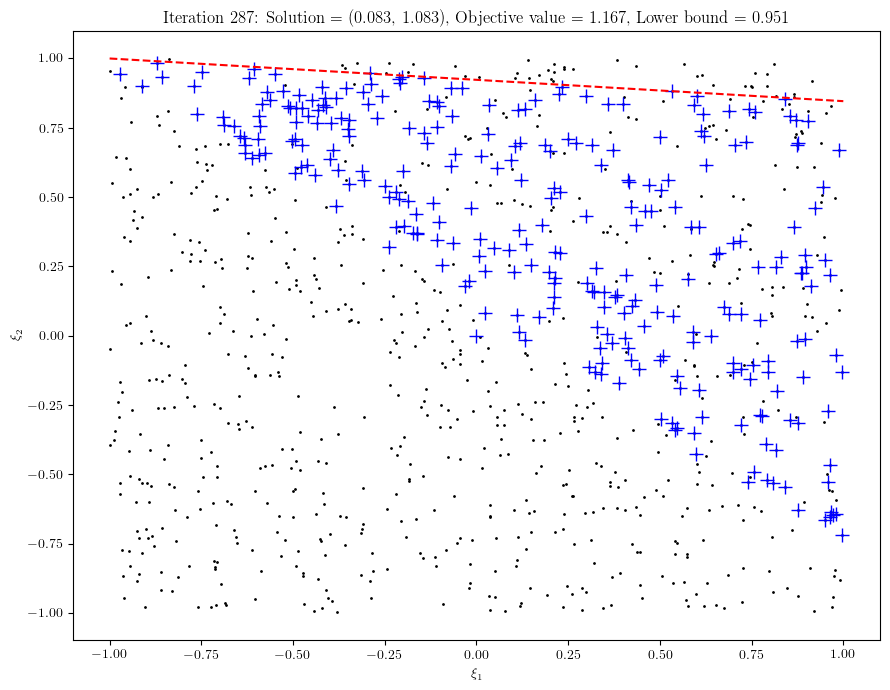

In [13]:
plot_solution(num_iter, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend)

In [34]:
def plot_solution(name, data, Z_arr, x, obj, lb, save_plot, plot_type, show_legend):
    plt.plot(data[:,0],data[:,1],'ok',markersize=1, label = 'All scenarios')
    
    if Z_arr != None:
        plt.plot(Z_arr[:,0],Z_arr[:,1], color='blue', marker='+', linestyle='',
                 markersize=10, label = 'Chosen scenarios')

    # Add constraint to plot, given solution x
    constraint_x = np.linspace(-1, 1, 1000)
    constraint_y = (1 - x[0]*constraint_x) / x[1]
    plt.plot(constraint_x, constraint_y, '--r', label = r'$\xi_{1}x_{1}^{*}+\xi_{2}x_{2}^{*}\leq 1$' ,alpha=1)

    plt.title(name +': Solution = (' + str(round(x[0],3)) + ', ' 
              + str(round(x[1],3)) + '), Objective value = ' + str(round(obj,3)) 
              + ', Lower bound = '+ str(round(lb,3)))
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    
    if show_legend:
        plt.legend(bbox_to_anchor=(1.01, 0.6), loc='upper left')
    
    plt.tight_layout()
    
    if save_plot:
        plot_name = 'Figures/ToyModel/Scenarios_wConstraint_'+name+'_N=' + str(N) + '_alpha=' + str(alpha) + "_beta="+ str(beta)
        plt.savefig(plot_name + '.' + plot_type)
    
    plt.show()

[0.941 0.058]
0.9333482795442705
1.2222222222222223


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


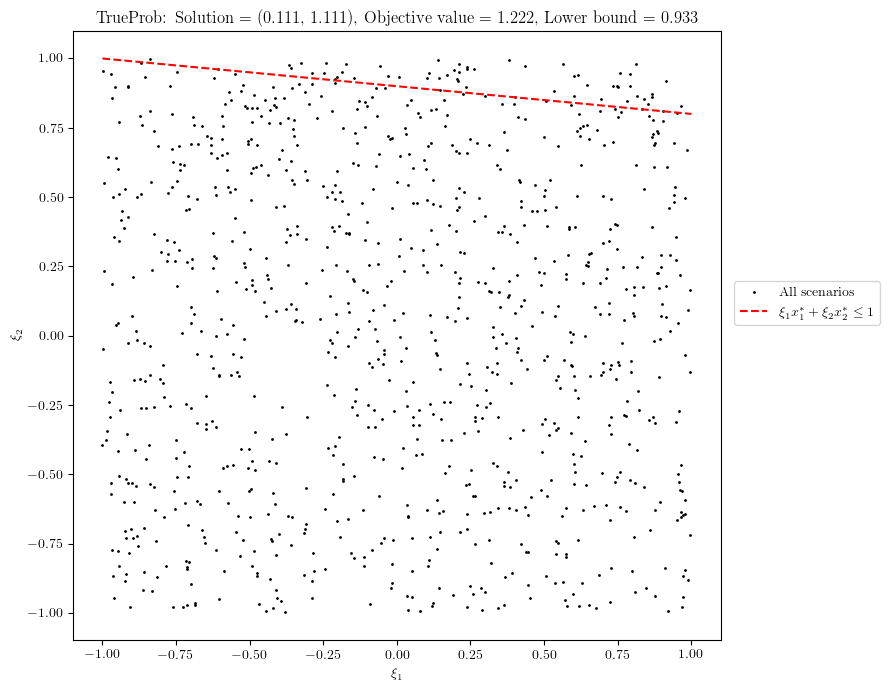

In [37]:
[x_true, obj_true] = toymodel_true(beta)
constr = data.dot(x_true)
p = np.array([len(constr[constr<=1])/N,len(constr[constr>1])/N])
lb = lowbound(p,r, par, phi_div)
print(p)
print(lb)
print(obj_true)

plot_solution("TrueProb", data, None, x_true, obj_true, lb, True, 'eps', True)

In [29]:
# Use bisection-esque search to determine minimum p_1 for which lowbound >= beta
p_hat = np.array([beta, 1-beta])
delta = 0.1
epsilon = 0.00001
l_hat = lowbound(p_hat, r, par, phi_div)
p_hat_prev = p_hat
while True:
    if p_hat[0] + delta > 1 - epsilon:
        delta = delta/10
    p_hat = p_hat + np.array([delta, -delta])
    l_hat = lowbound(p_hat, r, par, phi_div)
    #print('p :', p_hat, ' l :', l_hat)
    if l_hat < beta:
        continue
    else:
        delta = delta / 10
        if delta < epsilon:
            break
        else:
            p_hat = p_hat_prev
print('FINAL: p :', p_hat, ' l :', l_hat)
p_min = p_hat
l_min = l_hat

FINAL: p : [0.95743 0.04257]  l : 0.9500046366573515


In [30]:
def opt_set(data, F, M):
    N = len(data)
    x = cp.Variable(2, nonneg = True)
    y = cp.Variable(N, boolean = True)
    constraints = [x[0]-x[1] <= -1, x <= 10, data @ x <= 1 + (1-y)*M, cp.sum(y) >= F]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, y.value, prob.value)
    

[0.08100608 1.08100608] 958.0 1.1620121677030626


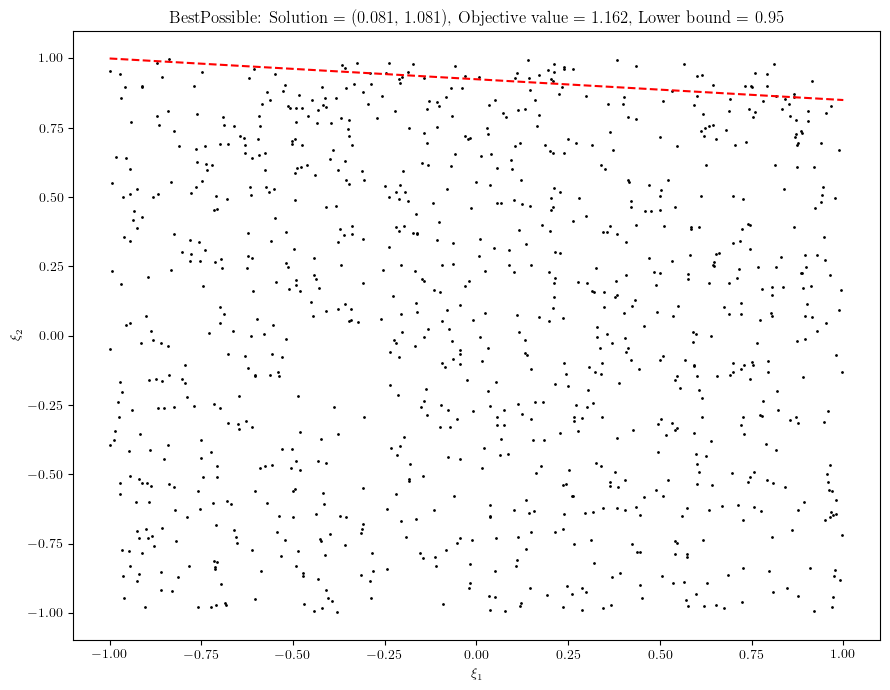

In [39]:
M = 1000
F = np.ceil(p_min * N)
x_val, y_val, prob_val = opt_set(data, F, M)
print(x_val, np.sum(y_val), prob_val)

plot_solution("BestPossible", data, None, x_val, prob_val, l_min, True, 'eps', False)